In [2]:
# Import packages
import rasterio
import earthpy.plot as ep
from rasterio.merge import merge
from shapely.geometry import box, mapping
import json

import geopandas as gpd
import pandas as pd
import numpy as np

import keras
from keras import Sequential
from keras.layers import Conv1D, MaxPooling1D, Dense, Dropout, Flatten, Input, GlobalMaxPooling1D, MaxPooling2D
from keras.callbacks import EarlyStopping
from keras import Model
from keras.utils import to_categorical, plot_model, model_to_dot

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, classification_report
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.colors import from_levels_and_colors


import ee
import geemap

import os
from datetime import datetime
import folium

import xarray
from shapely.geometry import JOIN_STYLE, Polygon, MultiPolygon

import json

c:\Users\juane\miniforge3\envs\satellite_class_3\Lib\site-packages\h5py\__init__.py:36: UserWarning: h5py is running against HDF5 1.14.3 when it was built against 1.14.2, this may cause problems
  _warn(("h5py is running against HDF5 {0} when it was built against {1}, "


In [3]:
ee.Initialize()

SEED = 2024
FEATURES = ['B1', 'B2', 'B3', 'B4', 'B5', 'B6', 'B7', 'B9']
LABEL = ['type']
N_CLASSES = 4
CLASSES = [0, 1, 2, 3]
# samples['int_type'] = samples['type'].map({'urban': 0, 'deep_ocean': 1, 'shallow_waters': 2, 'rural': 3})
PALETTE = ['#F08080', '#D2B48C', '#87CEFA', '#008080']

## Load Data

In [4]:
# Load the Cuba territorial seas shapefile (inside the data folder) using geopandas
cuba_territorial_seas = gpd.read_file(os.path.join('data', 'eez_12nm.zip'))


# The shapefile has only the shape of the territorial seas of Cuba, so we need to fill in the ring to capture
# the whole island.
def close_holes(poly: Polygon) -> Polygon:
        """
        Close polygon holes by limitation to the exterior ring.
        Args:
            poly: Input shapely Polygon
        Example:
            df.geometry.apply(lambda p: close_holes(p))
        """
        if poly.interiors:
            return Polygon(list(poly.exterior.coords))
        else:
            return poly

cuba_territorial_seas = cuba_territorial_seas.geometry.apply(lambda p: close_holes(p))

In [5]:
# Define the image collection and geometry
image_collection = ee.ImageCollection("LANDSAT/LC08/C02/T1_TOA")

# Convert GeoPandas object to Earth Engine geometry
cuba_json = cuba_territorial_seas.to_json()

geometry_cuba = ee.FeatureCollection(json.loads(cuba_json))

## Filter Data

In [6]:
# Define a function to mask clouds for Landsat 8 images
def mask_clouds(image):
    L8cloudShadowBitMask = 1 << 3
    L8cloudsBitMask = 1 << 4
    L8Qa = image.select('QA_PIXEL')
    L8mask = L8Qa.bitwiseAnd(L8cloudShadowBitMask).eq(0) \
             .And(L8Qa.bitwiseAnd(L8cloudsBitMask).eq(0))
    return image.updateMask(L8mask)

In [7]:
geometry_idlj = ee.Geometry.Polygon(
    [[[-83.21494438818296,21.356673185906914],
      [-82.5032363193353,21.356673185906914],
      [-82.5032363193353,21.93872306614785],
      [-83.21494438818296,21.93872306614785]]])

In [8]:
# Filter the Landsat images
landsat_cuba = image_collection.filterBounds(geometry_cuba).map(mask_clouds)

# Define start and end dates
start_date = ee.Date('2023-01-01')
end_date = ee.Date('2023-12-31')

# Filter by date
landsat_cuba = landsat_cuba.filterDate(start_date, end_date)

# Get median image, only for the geometry of cuba, and for bands with 30m resolution
median_image = landsat_cuba.median().clip(geometry_cuba).select(FEATURES)

# Get median image, only for the geometry of Isla de la Juventud
# We will use this image for visually displaying the model results
median_idlj = landsat_cuba.median().clip(geometry_idlj).select(FEATURES)

# Display the map
mapid = median_image.getMapId({'min': 0, 'max': 0.3, 'bands': ['B4', 'B3', 'B2']})

In [9]:
# Create a Folium map object
map = folium.Map(location=[22, -80], zoom_start=7)

# Add the Landsat image layer
folium.TileLayer(
    tiles=mapid['tile_fetcher'].url_format,
    attr='Google Earth Engine',
    overlay=True,
    name='Landsat Image',
).add_to(map)

# Add layer control
folium.LayerControl().add_to(map)

# Display the map
map

## Create Isla de La Juventud Cutout

We will also save it as a tif file to be able to work with it as a rasterio object.

In [10]:
# Function to split geometry into smaller subregions
def split_geometry(geometry, num_parts):
    bounds = geometry.bounds().getInfo()
    # Extracting bounding coordinates
    xmin = bounds['coordinates'][0][0][0]
    ymin = bounds['coordinates'][0][0][1]
    xmax = bounds['coordinates'][0][2][0]
    ymax = bounds['coordinates'][0][2][1]
    width = (xmax - xmin) / num_parts
    height = (ymax - ymin) / num_parts

    subgeometries = []
    for i in range(num_parts):
        for j in range(num_parts):
            subgeometry = box(xmin + i * width, ymin + j * height,
                              xmin + (i + 1) * width, ymin + (j + 1) * height)
            subgeometries.append(subgeometry)

    return subgeometries

In [11]:
# Create a directory for temporary files if it doesn't exist
temp_dir = "temporary"
if not os.path.exists(temp_dir):
    os.makedirs(temp_dir)

output_path = os.path.join(temp_dir, "ildj_median_2023_merged.tif")
if not os.path.exists(output_path):
    # Split geometry into smaller subregions (to bypass Earth Engine export limit)
    subgeometries = split_geometry(geometry_idlj, num_parts=3)

    # Export and download each subregion
    for i, subgeometry in enumerate(subgeometries):
        output_filename = os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif")
        # Convert Shapely geometry to GeoJSON
        geojson_geometry = json.dumps(mapping(subgeometry))
        task = geemap.ee_export_image(median_idlj, filename=output_filename, region=geojson_geometry, scale=30)
        print(f"Exporting {output_filename}...")

    # Read and merge downloaded images
    output_files = [os.path.join(temp_dir, f"ildj_median_2023_part_{i}.tif") for i in range(len(subgeometries))]
    datasets = [rasterio.open(file) for file in output_files]
    merged, transform = merge(datasets)

    # Close the datasets
    for dataset in datasets:
        dataset.close()

    # Update the metadata
    profile = datasets[0].profile
    profile.update({"height": merged.shape[1], "width": merged.shape[2], "transform": transform})

    # Output merged image
    with rasterio.open(output_path, "w", **profile) as dst:
        dst.write(merged)

    # Delete smaller TIFF files
    for file in output_files:
        os.remove(file)
else:
    print("Found existing ildj_median_2023_merged.tif file. Using that instead.")

Found existing ildj_median_2023_merged.tif file. Using that instead.


In [12]:
median_image_raster = rasterio.open(output_path)
height = median_image_raster.height
width = median_image_raster.width
shape = (height, width)

## Set up Samples

In [41]:
# Check if samples file exists
samples_path = os.path.join(temp_dir, "cuba_samples.csv")
if not os.path.exists(samples_path):
    print("Unable to find Cuba samples file. Creating a new one, this may take a while...")

    # Load cuba_samples_polygons.geojson as an Earth Engine FeatureCollection
    cuba_samples = geemap.geojson_to_ee(os.path.join('data', 'cuba_samples_polygons.geojson'))

    # Sample the median image at the locations of the samples
    extract = median_image.sampleRegions(
        collection=cuba_samples,
        scale=30,
        properties=['type']
    )

    # Convert extract to a pandas DataFrame
    samples = geemap.ee_to_df(extract)

    # Save the samples to a CSV file in the temporary directory
    samples.to_csv(os.path.join(temp_dir, "cuba_samples.csv"), index=False)

else:
    print("Found existing Cuba samples file. Using that instead.")
    samples = pd.read_csv(samples_path)


Found existing Cuba samples file. Using that instead.


In [42]:
# Randomly keep the same number of samples for each class (800 samples of each)
samples = samples.groupby('type').apply(lambda x: x.sample(800, random_state=SEED)).reset_index(drop=True)

# Add column 'int_type' that gives an integer value to each class
samples['int_type'] = samples['type'].map({'urban': 0, 'deep_ocean': 1, 'shallow_waters': 2, 'rural': 3})

samples = samples.sample(frac = 1, random_state=SEED) # Shuffle data

samples.head()

,B1,B2,B3,B4,B5,B6,B7,B9,type,int_type
2384,0.193582,0.187263,0.138191,0.057488,0.032091,0.020003,0.014359,0.000798,shallow_waters,2
2218,0.130938,0.113411,0.090096,0.047509,0.023767,0.013515,0.009922,0.000720,shallow_waters,2
2771,0.182760,0.174834,0.164238,0.179217,0.243943,0.287919,0.246690,0.001529,urban,0
3014,0.165332,0.151601,0.153781,0.172799,0.276494,0.235444,0.165103,0.001067,urban,0
1086,0.113144,0.088319,0.076066,0.043579,0.376037,0.156439,0.057688,0.001039,rural,3


In [43]:
# Split data into training and testing (80% training, 20% testing)
train = samples.sample(frac=0.8, random_state=SEED)
test = samples.drop(train.index)

# Split between features and label
train_features = train[FEATURES]
train_label = train[['int_type']]
test_features = test[FEATURES]
test_label = test[['int_type']]

# Function to reshape array input
def reshape_input(array):
  shape = array.shape
  return array.reshape(shape[0], shape[1], 1)

# Convert samples dataframe (pandas) to numpy array
train_input = reshape_input(train_features.to_numpy())
test_input = reshape_input(test_features.to_numpy())

# Also make label data to categorical
train_output = to_categorical(train_label.to_numpy(), num_classes=N_CLASSES + 1)
test_output = to_categorical(test_label.to_numpy(), num_classes=N_CLASSES + 1)

# Show the data shape
print(f'Train features: {train_input.shape}\nTest features: {test_input.shape}\nTrain label: {train_output.shape}\nTest label: {test_output.shape}')

Train features: (2560, 8, 1)
Test features: (640, 8, 1)
Train label: (2560, 5)
Test label: (640, 5)


## Deep Learning Model

### Make Model

In [44]:
# Make model for our data
# Input shape
train_shape = train_input.shape
input_shape = (train_shape[1], train_shape[2])

# Model parameter
neuron = 64
drop = 0.2
kernel = 2
pool = 1

# Make sequential model
model = Sequential([
  Input(input_shape),
  Conv1D(neuron * 1, kernel, activation='relu'),
  Conv1D(neuron * 1, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  Conv1D(neuron * 2, kernel, activation='relu'),
  Conv1D(neuron * 2, kernel, activation='relu'),
  MaxPooling1D(pool),
  Dropout(drop),
  GlobalMaxPooling1D(),
  Dense(neuron * 2, activation='relu'),
  Dropout(drop),
  Dense(neuron * 1, activation='relu'),
  Dropout(drop),
  Dense(N_CLASSES + 1, activation='softmax')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv1d (Conv1D)                 │ (None, 7, 64)          │           192 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_1 (Conv1D)               │ (None, 6, 64)          │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d (MaxPooling1D)    │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 6, 64)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_2 (Conv1D)               │ (None, 5, 128)         │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 4, 128)         │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_1 (MaxPooling1D)  │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 4, 128)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d            │ (None, 128)            │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 128)            │        16,512 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 128)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         8,256 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 64)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 82,949 (324.02 KB)

 Trainable params: 82,949 (324.02 KB)

 Non-trainable params: 0 (0.00 B)

### Train Model

In [45]:
# Compline the model
model.compile(
    optimizer='Adam',
    loss='categorical_crossentropy',  # Updated the loss parameter
    metrics=['accuracy']
)

# Create callback to stop training if loss not decreasing
stop = EarlyStopping(
    monitor='loss',
    patience=5
)

# Fit the model
result = model.fit(
    x=train_input, y=train_output,
    validation_data=(test_input, test_output),
    batch_size=1024,
    callbacks=[stop],
    epochs=100,
)

Epoch 1/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 8s 380ms/step - accuracy: 0.2902 - loss: 1.6046 - val_accuracy: 0.2562 - val_loss: 1.5898
Epoch 2/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 95ms/step - accuracy: 0.3500 - loss: 1.5802 - val_accuracy: 0.2562 - val_loss: 1.5557
Epoch 3/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 120ms/step - accuracy: 0.3181 - loss: 1.5368 - val_accuracy: 0.2562 - val_loss: 1.4990
Epoch 4/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step - accuracy: 0.3083 - loss: 1.4686 - val_accuracy: 0.2562 - val_loss: 1.4143
Epoch 5/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step - accuracy: 0.3074 - loss: 1.3830 - val_accuracy: 0.2562 - val_loss: 1.3151
Epoch 6/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.3755 - loss: 1.2960 - val_accuracy: 0.7094 - val_loss: 1.1978
Epoch 7/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 101ms/step - accuracy: 0.5023 - loss: 1.1670 - val_accuracy: 0.7359 - val_loss: 1.0415
Epoch 8/100
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 106ms/step - accuracy: 0.5938 - loss: 1.0157 - val_accuracy: 0.7359 - val

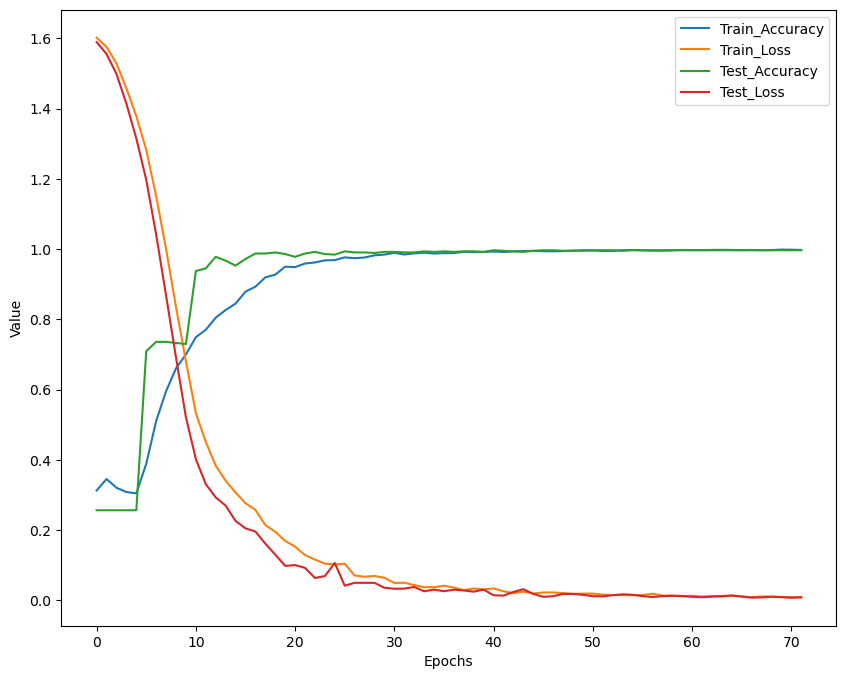

In [46]:
# Show history
history = pd.DataFrame(result.history)

plt.figure(figsize = (10, 8))
plt.plot(range(len(history['accuracy'].values.tolist())), history['accuracy'].values.tolist(), label = 'Train_Accuracy')
plt.plot(range(len(history['loss'].values.tolist())), history['loss'].values.tolist(), label = 'Train_Loss')
plt.plot(range(len(history['val_accuracy'].values.tolist())), history['val_accuracy'].values.tolist(), label = 'Test_Accuracy')
plt.plot(range(len(history['val_loss'].values.tolist())), history['val_loss'].values.tolist(), label = 'Test_Loss')
plt.xlabel('Epochs')
plt.ylabel('Value')
plt.legend()
plt.show()

### Run Model on Isla de La Juventud

70/70 ━━━━━━━━━━━━━━━━━━━━ 41s 580ms/step


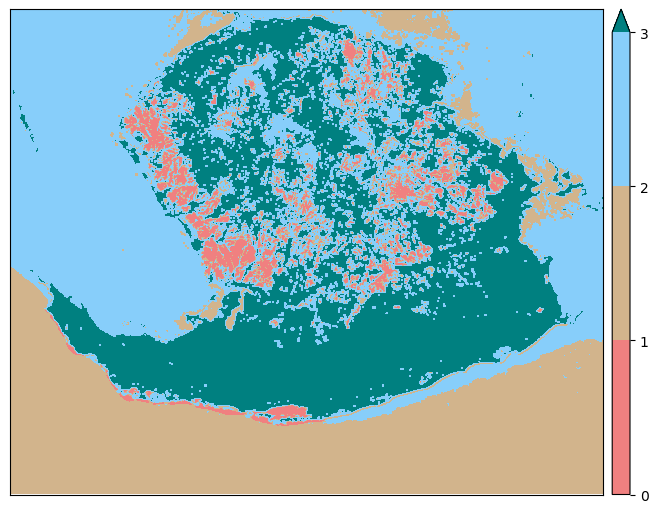

<Axes: >

In [47]:
# Predict image using the model
image_input = []
for x in range(8):
  image_input.append(median_image_raster.read(x + 1))
image_input = reshape_input(np.stack(image_input).reshape(8, -1).T)

# Predict
prediction = model.predict(image_input, batch_size=4096*20)
prediction = np.argmax(prediction, 1)
prediction = prediction.reshape(shape[0], shape[1])

# Visualize
plot_size = (8, 8)
cmap, norm = from_levels_and_colors(CLASSES, PALETTE, extend='max')
ep.plot_bands(prediction, cmap=cmap, norm=norm, figsize=plot_size)